# Load Data

In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark2.4.5
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
# install findspark
!pip install -q findspark
# Google Colab has Java 11 available, test it using below command -
!ls /usr/lib/jvm
#install pyarrow
!pip install -U pyarrow
# Tietjen-Moore test package
!pip install scikit_posthocs

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark_params = {
"spark.executor.memory" : "4g",
"spark.driver.memory": "4g",
"spark.memory.fraction": "0.9"}
for param, value in spark_params.items():
  spark.conf.set(param, value)

!wget "https://datasets.imdbws.com/name.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.akas.tsv.gz"
!wget "https://datasets.imdbws.com/title.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.crew.tsv.gz"
!wget "https://datasets.imdbws.com/title.episode.tsv.gz"
!wget "https://datasets.imdbws.com/title.principals.tsv.gz"
!wget "https://datasets.imdbws.com/title.ratings.tsv.gz"

title_ratings = spark.read.csv("title.ratings.tsv.gz", sep='\t', header=True)
title_basics = spark.read.csv("title.basics.tsv.gz", sep='\t', header=True)

--2022-11-08 18:31:31--  https://datasets.imdbws.com/name.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 18.160.46.123, 18.160.46.72, 18.160.46.19, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|18.160.46.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236081246 (225M) [binary/octet-stream]
Saving to: ‘name.basics.tsv.gz.1’

name.basics.tsv.gz. 100%[===================>] 225.14M  95.4MB/s    in 2.4s    

2022-11-08 18:31:34 (95.4 MB/s) - ‘name.basics.tsv.gz.1’ saved [236081246/236081246]

--2022-11-08 18:31:34--  https://datasets.imdbws.com/title.akas.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 18.160.46.123, 18.160.46.72, 18.160.46.19, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|18.160.46.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286852961 (274M) [binary/octet-stream]
Saving to: ‘title.akas.tsv.gz.1’

title.akas.tsv.gz.1 100%[===================>] 273.

In [3]:
print(title_basics.show(5))
print(title_ratings.show(5))

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [4]:
import pandas as pd
from scipy import stats
from statistics import mean, stdev

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t

import scikit_posthocs

from scipy.stats import pearsonr

# Normality Tests

In [5]:
def compare_with_normal_dist(sample):
  # Create a gaussian distribution
  m = mean(sample)
  sd = stdev(sample)
  x = np.random.normal(loc = m, scale = sd, size = len(sample))

  # Binning
  n_x, bins_x = np.histogram(x, bins = int(np.ceil(np.sqrt(x.size))))
  n_y, bins_y = np.histogram(sample, bins = int(np.ceil(np.sqrt(len(sample)))))

  # Normalizings
  n_x = n_x / len(x) / len(bins_y)
  n_y = n_y / len(sample) / len(bins_x)

  # Plotting
  plt.plot(bins_x[:-1], n_x)
  plt.plot(bins_y[:-1], n_y)
  plt.show()  

def histogram(sample):
  plt.hist(sample)
  plt.show() 

Get necessery values

In [6]:
to_filter = ['\\N', 'Reality-TV', 'Talk-Show', 'Documentary', 
             'Animation,Comedy,Family', 'Game-Show', 'Game-Show,Reality-TV']

runtime = (title_basics.select('runtimeMinutes').
           filter(~title_basics.runtimeMinutes.isin(to_filter)))
runtime = list(runtime.toPandas()['runtimeMinutes'])
runtime = [float(x) for x in runtime]

ratings = list(title_ratings.select('averageRating').toPandas()['averageRating'])
ratings = [float(x) for x in ratings]

votes = list(title_ratings.select('numVotes').toPandas()['numVotes'])
votes = [float(x) for x in votes]

Ratings distribution

KstestResult(statistic=0.07666292631247779, pvalue=0.0)
mean: 6.949523867635122, standard deviation: 1.3906164850084959


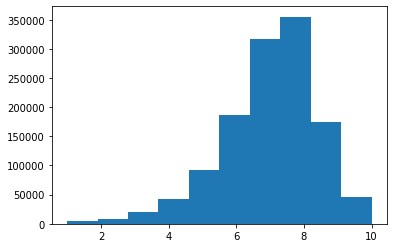

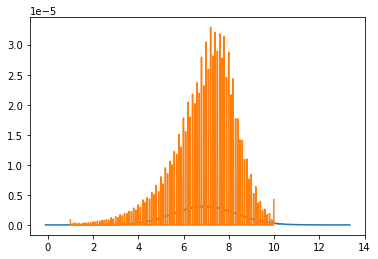

In [7]:
m = mean(ratings)
sd = stdev(ratings)

print(stats.kstest([(x - m) / sd for x in ratings], "norm"))
print(f"mean: {m}, standard deviation: {sd}")

histogram(ratings)
compare_with_normal_dist(ratings)

Number of votes distribution

KstestResult(statistic=0.47606909600802344, pvalue=0.0)
mean: 1042.048970862032, standard deviation: 17277.84294273762


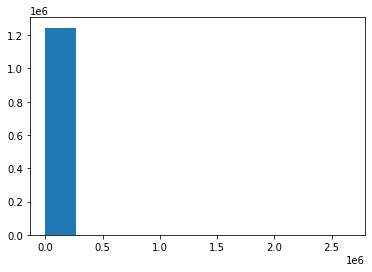

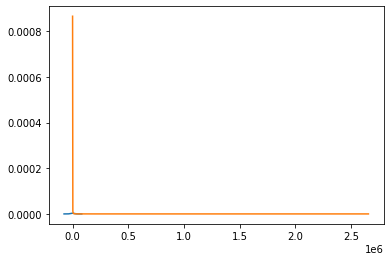

In [8]:
m = mean(votes)
sd = stdev(votes)

print(stats.kstest([(x - m) / sd for x in votes], "norm"))
print(f"mean: {m}, standard deviation: {sd}")

histogram(votes)
compare_with_normal_dist(votes)

Run time distribution

KstestResult(statistic=0.292822506957265, pvalue=0.0)
mean: 43.93277316178568, standard deviation: 78.75441043182758


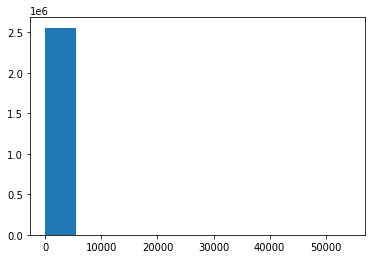

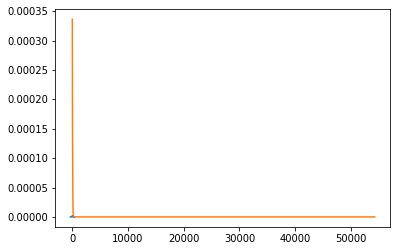

In [9]:
m = mean(runtime)
sd = stdev(runtime)

print(stats.kstest([(x - m) / sd for x in runtime], "norm"))
print(f"mean: {m}, standard deviation: {sd}")

histogram(runtime)
compare_with_normal_dist(runtime)

# Outlier analysis

In [10]:
scikit_posthocs.outliers_tietjen(ratings[:1000], 2)

array([5.7, 5.8, 6.5, 5.6, 6.2, 5.1, 5.4, 5.4, 5.2, 6.9, 5.3, 7.4, 5.7,
       7.1, 6.2, 5.9, 4.6, 5.3, 5.1, 4.8, 5.1, 5.7, 4.2, 3.9, 5.7, 5.6,
       5.1, 5.9, 5.2, 5.5, 5. , 5.5, 5. , 5.5, 4.4, 4.4, 4.2, 3.3, 4.1,
       6.7, 4.1, 3.2, 3.9, 3.9, 4.1, 3.3, 4.8, 5. , 4. , 3.5, 4.3, 3.1,
       4.9, 3.5, 2.8, 4.4, 4.2, 3.2, 7.6, 3.9, 6.3, 3.2, 2.8, 3.1, 3. ,
       5.6, 3.6, 4.9, 6.4, 3.2, 3.4, 3.3, 4.5, 6.3, 4.5, 4.4, 3.7, 4.3,
       3.9, 4. , 4.8, 4.6, 4.3, 4.7, 4. , 4.7, 4.2, 6.2, 3.8, 6.7, 4.5,
       4.7, 4.4, 4.8, 4.3, 4.9, 5.2, 4.6, 4.8, 4.5, 4.6, 5.4, 5.6, 5. ,
       4.4, 5.2, 4.4, 4.5, 4.4, 4.4, 4.5, 4.3, 5.1, 4.9, 5.2, 5.2, 5.2,
       5.3, 5.3, 4.2, 5.1, 5.7, 5.2, 4.5, 5.8, 4.4, 5.8, 6.6, 5.1, 5.7,
       5.1, 6.3, 4.8, 6.5, 4.5, 6.5, 5.3, 4.9, 5.1, 4.5, 4.9, 5.1, 3.2,
       5. , 5.2, 3. , 4.6, 5.3, 4.8, 6.2, 5.7, 3.7, 5.2, 3.8, 3.7, 2.8,
       5.2, 5.3, 3.3, 5.4, 5. , 5. , 4.6, 3.4, 4.1, 2.8, 3.7, 5.2, 6.1,
       4.5, 4.6, 5. , 4.6, 4.6, 5.2, 4.6, 6.8, 4.9, 5.9, 4.9, 3.

In [11]:
scikit_posthocs.outliers_tietjen(votes, 2)

KeyboardInterrupt: ignored

In [ ]:
scikit_posthocs.outliers_tietjen(runtime, 2)

# Correlation

In [12]:
def pearson_corr_test(vec1, vec2):
  stat, p = pearsonr(vec1, vec2)
  print(f'Statistic: {stat}, p-value: {p}')

In [13]:
data = title_basics.join(title_ratings, 
                         how='inner', 
                         on='tconst').select(['averageRating', 
                                              'numVotes', 
                                              'runtimeMinutes'])
data = data.filter(~data.runtimeMinutes.isin(to_filter))
data = data.distinct().toPandas()
data = data.apply(pd.to_numeric)

In [14]:
print(data.corr())

                averageRating  numVotes  runtimeMinutes
averageRating        1.000000  0.031947       -0.054170
numVotes             0.031947  1.000000        0.027248
runtimeMinutes      -0.054170  0.027248        1.000000


In [15]:
pearson_corr_test(data.loc[:, 'numVotes'], data.loc[:, 'averageRating'])
pearson_corr_test(data.loc[:, 'numVotes'], data.loc[:, 'runtimeMinutes'])
pearson_corr_test(data.loc[:, 'runtimeMinutes'], data.loc[:, 'averageRating'])

Statistic: 0.03194730383115843, p-value: 3.50660057244544e-114
Statistic: 0.027248361726413067, p-value: 1.4089754294513317e-83
Statistic: -0.05417025802967565, p-value: 0.0
